In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import optuna
import optuna.visualization as vis
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
batch_size = 32
img_height = 8
img_width = 8
train_data_dir = "C:/Users/lanzi/Desktop/TRAIN_SET CASA"
val_data_dir = "C:/Users/lanzi/Desktop/VAL_SET CASA"
test_data_dir = "C:/Users/lanzi/Desktop/TEST_SET CASA"

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

train_ds_90 = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

train_ds_180 = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  val_data_dir,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = train_ds.class_names
print("CLASSES:", class_names)

Found 16695 files belonging to 4 classes.
Found 16695 files belonging to 4 classes.
Found 16695 files belonging to 4 classes.
Found 9173 files belonging to 4 classes.
Found 8055 files belonging to 4 classes.
CLASSES: ['EMPTY', 'HAND', 'HANDWITHOBJECT', 'OBJECT']


In [5]:
def extract_flat_features(dataset):
    features = []
    labels = []
    
    for images, lbls in dataset:
        # Flatten each image in the batch
        flattened_images = np.reshape(images.numpy(), (images.shape[0], -1))
        features.append(flattened_images)
        labels.append(lbls.numpy())
    
    features = np.vstack(features)
    labels = np.hstack(labels)
    
    return features, labels

In [13]:
#train_ds = train_ds.concatenate(train_ds_90)
#train_ds = train_ds.concatenate(train_ds_180)

In [6]:
# Extract features and labels from the datasets
train_features, train_labels = extract_flat_features(train_ds)
val_features, val_labels = extract_flat_features(val_ds)
test_features, test_labels = extract_flat_features(test_ds)

# OPTUNA HYPERPARAMETERS OPTIMIZATION 

In [7]:
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    
    clf.fit(train_features, train_labels)
    y_pred = clf.predict(val_features)
    accuracy = accuracy_score(val_labels, y_pred)
    
    return accuracy

# Create a study object and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best parameters found
print(study.best_params)


[I 2024-08-31 11:43:03,563] A new study created in memory with name: no-name-296efd74-1c53-413c-8016-bcbc76068192
[I 2024-08-31 11:43:03,706] Trial 0 finished with value: 0.32704676768777935 and parameters: {'n_estimators': 57, 'max_depth': 5, 'min_samples_split': 0.810649083976404}. Best is trial 0 with value: 0.32704676768777935.
[I 2024-08-31 11:43:04,025] Trial 1 finished with value: 0.4215632835495476 and parameters: {'n_estimators': 48, 'max_depth': 12, 'min_samples_split': 0.4880180303560476}. Best is trial 1 with value: 0.4215632835495476.
[I 2024-08-31 11:43:04,788] Trial 2 finished with value: 0.7471928485773466 and parameters: {'n_estimators': 44, 'max_depth': 6, 'min_samples_split': 0.11054931969957449}. Best is trial 2 with value: 0.7471928485773466.
[I 2024-08-31 11:43:04,971] Trial 3 finished with value: 0.16352338384388967 and parameters: {'n_estimators': 75, 'max_depth': 21, 'min_samples_split': 0.9974217264041474}. Best is trial 2 with value: 0.7471928485773466.
[I 20

{'n_estimators': 19, 'max_depth': 30, 'min_samples_split': 0.10099189488608624}


In [8]:
vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()
vis.plot_slice(study).show()

In [10]:
best_hyperparams = study.best_params
clf_best = RandomForestClassifier(n_estimators=best_hyperparams['n_estimators'], max_depth=best_hyperparams['max_depth'], min_samples_split=best_hyperparams['min_samples_split'])
clf_best.fit(train_features, train_labels)

RandomForestClassifier(max_depth=30, min_samples_split=0.10099189488608624,
                       n_estimators=19)

ACCURACY: 79.91%


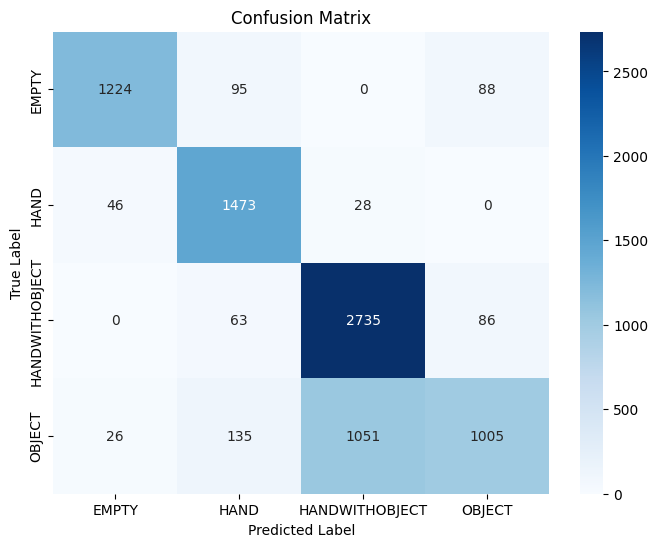

In [11]:
def compute_confusion_matrix(model, test_features, test_labels):
    y_true = []
    y_pred = []

    # Get predictions
    predictions = model.predict(test_features)
    
    # Extend true labels and predicted labels
    y_true.extend(test_labels)
    y_pred.extend(predictions)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    return conf_matrix, y_true, y_pred

def compute_accuracy_from_confusion_matrix(conf_matrix):
    # Accuracy is the sum of the diagonal elements (true positives) divided by the total number of samples
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    return accuracy

# Assuming `clf` is your trained SVM model and `test_features`, `test_labels` are your test data
conf_matrix, y_true, y_pred = compute_confusion_matrix(clf_best, test_features, test_labels)

accuracy = compute_accuracy_from_confusion_matrix(conf_matrix)
print(f"ACCURACY: {accuracy * 100:.2f}%")

# Function to plot the confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names for your classes
class_names = ["EMPTY", "HAND", "HANDWITHOBJECT", "OBJECT"]

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, class_names)
